Michael Haugan <br>
MSDS 422 - Winter 2019 <br>
Assignment 6: Neural Networks <br>

# overview
Tested neural network structures should be explored within a benchmark experiment, a factorial design with at least two levels on each of two experimental factors (at least a 2x2 completely crossed design). But due to the time required to fit each neural network, we will observe only one trial for each cell in the design.  You will build your models on train.csv and submit your forecasts for test.csv to Kaggle.com, providing your name and user ID for each experimental trial..

An example experiment could include two values for the number of nodes per inner layer and two values for the number of inner layers. Various machine learning hyperparameter settings may be used.

Students are encouraged to work in study teams on this assignment, with the understanding that each student must run the code himself/herself and write an independent report of the experimental results. 

# objective
Suppose you are a financial institution evaluating machine learning technologies for optical character recognition. Initial testing is on the MNIST digits. What can you conclude from your benchmark study? Which neural network typology and hyperparameter settings would you recommend as being the most trustworthy?

# setup

In [4]:
# import packages and set parameters
SET_FIT_INTERCEPT = True
import numpy as np
from scipy.stats import kurtosis
from scipy.stats import skew
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model 
from time import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, make_scorer  
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import tensorflow as tf
from math import sqrt  # for root mean-squared error calculation

#suppress tf.logging
import logging
logging.getLogger('tensorflow').disabled = True

# suppress warning messages
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import warnings
warnings.filterwarnings('ignore')

# eda

In [21]:
# read in train and test data
train = pd.read_csv('MNIST_train.csv')
test = pd.read_csv("MNIST_test.csv")

In [3]:
# view train head
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# view data types, variables, and sample size for each
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [5]:
# how many of each digit?
train['label'].value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [22]:
# create x and y variables
X = train.drop(columns=['label'])
y = pd.DataFrame(train['label'])

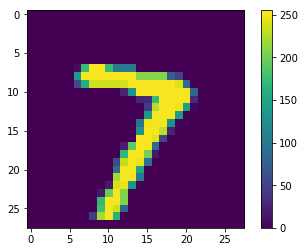

In [18]:
# view one digit
Xarray = X.values
some_digit = Xarray[872]
some_digit_image = some_digit.reshape(28, 28)
plt.figure()
plt.imshow(some_digit_image)
plt.colorbar()
plt.grid(False)
plt.show()

In [19]:
# because the pixel values will value in the range of 0 to 255 - we need to scale!

In [20]:
# view shape of train and test
print(y.shape)
print(test.shape)

(42000, 1)
(28000, 784)


# scale train and test x variables and conver to arrays

In [23]:
# training set scale and create arrays
X_arr = X.values.reshape(-1, 28*28) / 255.0
y_arr = y.values

In [24]:
# test set scale and create arrays
test_arr = test.values.reshape(-1, 28*28) / 255.0

In [25]:
# try minmax scaler
from sklearn.preprocessing import MinMaxScaler
X_arr2 = MinMaxScaler().fit_transform(X)
test_arr2 = MinMaxScaler().fit_transform(test)

# model building

### 2 layers with 10 nodes in each

In [115]:
dnn1_start_time = time()

feature_cols = [tf.feature_column.numeric_column("X", shape=[28 * 28])]

# 2 hidden layers each with 10 neurons, softmax output layer with 10 neurons
dnn_clf_1 = tf.estimator.DNNClassifier(hidden_units=[10,10], n_classes=10, feature_columns=feature_cols)

input_fn_1 = tf.estimator.inputs.numpy_input_fn(x={"X": X_arr}, y=y_arr, num_epochs=50, batch_size=50, 
                                                 shuffle=True)
dnn_clf_1.train(input_fn=input_fn_1)

dnn1_elapsed_time = time() - dnn1_start_time
print("Time elapsed: {:.3f}".format(dnn1_elapsed_time))

Time elapsed: 43.272


In [116]:
# evaluate accuracy on training set
train_input_fn_1 = tf.estimator.inputs.numpy_input_fn(x={"X": X_arr}, y=y_arr, shuffle=False)
eval_results_train_1 = dnn_clf_1.evaluate(input_fn=train_input_fn_1)
eval_results_train_1

{'accuracy': 0.94661903,
 'average_loss': 0.18002199,
 'loss': 22.98153,
 'global_step': 42000}

In [118]:
# confusion matrix
train_predictions_1 = dnn_clf_1.predict(input_fn=train_input_fn_1)
conf_mat_predictions_1 = [p['class_ids'][0] for p in train_predictions_1]
confusion_matrix_1 = tf.confusion_matrix(y_arr, conf_mat_predictions_1)

with tf.Session():
 print('\nConfusion Matrix model 1:\n', tf.Tensor.eval(confusion_matrix_1, feed_dict=None, session=None))


Confusion Matrix model 1:
 [[4015    0   19    3    6   17   41    6   20    5]
 [   1 4572   20   11   10    7   11   14   36    2]
 [  21   20 3942   42   33    3   31   35   35   15]
 [  10    7   71 4042    1   98    8   20   67   27]
 [   4    6   12    1 3912    2   34    2    8   91]
 [  41    6    6   60   26 3518   45   10   61   22]
 [  29    5   18    0   20   35 4012    0   18    0]
 [   5   18   37   10   25    9    0 4177    6  114]
 [  18   53   25   67   14   51   40    3 3720   72]
 [  20    6    7   31  143   19    1   67   46 3848]]


In [119]:
# predict digits on original test set
test_input_fn_1 = tf.estimator.inputs.numpy_input_fn(x={"X": test_arr}, y=None, shuffle=False)
raw_predictions_1 = dnn_clf_1.predict(input_fn=test_input_fn_1)
predictions_1 = [p['class_ids'][0] for p in raw_predictions_1]

In [123]:
# create dataframe with test digit predictions
dnn_clf_1_predicted_digits = pd.DataFrame()
dnn_clf_1_predicted_digits['ImageID'] = pd.Series(range(1,28001))
dnn_clf_1_predicted_digits['Label'] = predictions_1

In [125]:
dnn_clf_1_predicted_digits.head()

,ImageID,Label
0,1,2
1,2,0
2,3,9
3,4,2
4,5,3


In [126]:
# write to csv
dnn_clf_1_predicted_digits.to_csv("MNIST_Submission_dnn_clf_1.csv", encoding='utf-8', index=False)

kaggle score <br>
userid: 2682007 <br>
score: 0.92642 <br>

### 2 layers with 50 nodes in each

In [127]:
dnn2_start_time = time()

feature_cols = [tf.feature_column.numeric_column("X", shape=[28 * 28])]

# 2 hidden layers each with 50 neurons, softmax output layer with 10 neurons
dnn_clf_2 = tf.estimator.DNNClassifier(hidden_units=[50,50], n_classes=10, feature_columns=feature_cols)

input_fn_2 = tf.estimator.inputs.numpy_input_fn(x={"X": X_arr}, y=y_arr, num_epochs=50, batch_size=50, 
                                                 shuffle=True)
dnn_clf_2.train(input_fn=input_fn_2)

dnn2_elapsed_time = time() - dnn2_start_time
print("Time elapsed: {:.3f}".format(dnn2_elapsed_time))

Time elapsed: 49.819


In [128]:
# evaluate accuracy on training set
train_input_fn_2 = tf.estimator.inputs.numpy_input_fn(x={"X": X_arr}, y=y_arr, shuffle=False)
eval_results_train_2 = dnn_clf_2.evaluate(input_fn=train_input_fn_2)
eval_results_train_2

{'accuracy': 0.99878573,
 'average_loss': 0.009379443,
 'loss': 1.1973758,
 'global_step': 42000}

In [129]:
# confusion matrix
train_predictions_2 = dnn_clf_2.predict(input_fn=train_input_fn_2)
conf_mat_predictions_2 = [p['class_ids'][0] for p in train_predictions_2]
confusion_matrix_2 = tf.confusion_matrix(y_arr, conf_mat_predictions_2)

with tf.Session():
 print('\nConfusion Matrix model 1:\n', tf.Tensor.eval(confusion_matrix_2, feed_dict=None, session=None))


Confusion Matrix model 1:
 [[4131    0    0    0    0    0    0    0    1    0]
 [   0 4683    0    0    0    0    0    0    1    0]
 [   0    1 4173    0    0    0    0    1    2    0]
 [   1    0    2 4336    0    6    0    0    3    3]
 [   0    0    0    0 4071    0    0    0    0    1]
 [   0    0    0    2    0 3792    0    0    1    0]
 [   2    0    0    0    0    1 4133    0    1    0]
 [   0    2    2    1    0    0    0 4394    1    1]
 [   0    2    1    1    0    0    1    0 4056    2]
 [   3    0    0    0    1    1    0    1    2 4180]]


In [130]:
# predict digits on original test set
test_input_fn_2 = tf.estimator.inputs.numpy_input_fn(x={"X": test_arr}, y=None, shuffle=False)
raw_predictions_2 = dnn_clf_2.predict(input_fn=test_input_fn_2)
predictions_2 = [p['class_ids'][0] for p in raw_predictions_2]

In [131]:
# create dataframe with test digit predictions
dnn_clf_2_predicted_digits = pd.DataFrame()
dnn_clf_2_predicted_digits['ImageID'] = pd.Series(range(1,28001))
dnn_clf_2_predicted_digits['Label'] = predictions_2

In [132]:
dnn_clf_2_predicted_digits.head()

,ImageID,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [133]:
# write to csv
dnn_clf_2_predicted_digits.to_csv("MNIST_Submission_dnn_clf_2.csv", encoding='utf-8', index=False)

kaggle score <br>
userid: 2682007 <br>
score: 0.96585 <br>

### 5 layers with 10 nodes in each

In [134]:
dnn3_start_time = time()

feature_cols = [tf.feature_column.numeric_column("X", shape=[28 * 28])]

# 5 hidden layers each with 10 neurons, softmax output layer with 10 neurons
dnn_clf_3 = tf.estimator.DNNClassifier(hidden_units=[10,10,10,10,10], n_classes=10, feature_columns=feature_cols)

input_fn_3 = tf.estimator.inputs.numpy_input_fn(x={"X": X_arr}, y=y_arr, num_epochs=50, batch_size=50, 
                                                 shuffle=True)
dnn_clf_3.train(input_fn=input_fn_3)

dnn3_elapsed_time = time() - dnn3_start_time
print("Time elapsed: {:.3f}".format(dnn3_elapsed_time))

Time elapsed: 46.852


In [135]:
# evaluate accuracy on training set
train_input_fn_3 = tf.estimator.inputs.numpy_input_fn(x={"X": X_arr}, y=y_arr, shuffle=False)
eval_results_train_3 = dnn_clf_3.evaluate(input_fn=train_input_fn_3)
eval_results_train_3

{'accuracy': 0.9195,
 'average_loss': 0.2729888,
 'loss': 34.849632,
 'global_step': 42000}

In [136]:
# confusion matrix
train_predictions_3 = dnn_clf_3.predict(input_fn=train_input_fn_3)
conf_mat_predictions_3 = [p['class_ids'][0] for p in train_predictions_3]
confusion_matrix_3 = tf.confusion_matrix(y_arr, conf_mat_predictions_3)

with tf.Session():
 print('\nConfusion Matrix model 1:\n', tf.Tensor.eval(confusion_matrix_3, feed_dict=None, session=None))


Confusion Matrix model 1:
 [[3937    0   18    6   18   72   61   13    7    0]
 [   1 4573   24    5    8    7    3   10   46    7]
 [  34   26 3829   39   44   35   73   49   46    2]
 [  10    1  132 3751    7  239    5   39  144   23]
 [  11   10    7    0 3813    4   55   12   10  150]
 [  52    0   21  160   72 3206   44   12  209   19]
 [  36    4   17    0   32   33 3998    0   17    0]
 [  12   14   32   15   33    3    0 4202    3   87]
 [   7   37   27   92   53  174   25   14 3620   14]
 [  19    9    1   37  220   41    0  145   26 3690]]


In [137]:
# predict digits on original test set
test_input_fn_3 = tf.estimator.inputs.numpy_input_fn(x={"X": test_arr}, y=None, shuffle=False)
raw_predictions_3 = dnn_clf_3.predict(input_fn=test_input_fn_3)
predictions_3 = [p['class_ids'][0] for p in raw_predictions_3]

In [138]:
# create dataframe with test digit predictions
dnn_clf_3_predicted_digits = pd.DataFrame()
dnn_clf_3_predicted_digits['ImageID'] = pd.Series(range(1,28001))
dnn_clf_3_predicted_digits['Label'] = predictions_3

In [139]:
dnn_clf_3_predicted_digits.head()

,ImageID,Label
0,1,2
1,2,0
2,3,4
3,4,4
4,5,3


In [140]:
# write to csv
dnn_clf_3_predicted_digits.to_csv("MNIST_Submission_dnn_clf_3.csv", encoding='utf-8', index=False)

kaggle score <br>
userid: 2682007 <br>
score: 0.89814 <br>

### 5 layers with 50 nodes in each

In [142]:
dnn4_start_time = time()

feature_cols = [tf.feature_column.numeric_column("X", shape=[28 * 28])]

# 5 hidden layers each with 50 neurons, softmax output layer with 10 neurons
dnn_clf_4 = tf.estimator.DNNClassifier(hidden_units=[50,50,50,50,50], n_classes=10, feature_columns=feature_cols)

input_fn_4 = tf.estimator.inputs.numpy_input_fn(x={"X": X_arr}, y=y_arr, num_epochs=50, batch_size=50, 
                                                 shuffle=True)
dnn_clf_4.train(input_fn=input_fn_4)

dnn4_elapsed_time = time() - dnn4_start_time
print("Time elapsed: {:.3f}".format(dnn4_elapsed_time))

Time elapsed: 59.391


In [143]:
# evaluate accuracy on training set
train_input_fn_4 = tf.estimator.inputs.numpy_input_fn(x={"X": X_arr}, y=y_arr, shuffle=False)
eval_results_train_4 = dnn_clf_4.evaluate(input_fn=train_input_fn_4)
eval_results_train_4

{'accuracy': 0.9989762,
 'average_loss': 0.004706758,
 'loss': 0.60086274,
 'global_step': 42000}

In [144]:
# confusion matrix
train_predictions_4 = dnn_clf_4.predict(input_fn=train_input_fn_4)
conf_mat_predictions_4 = [p['class_ids'][0] for p in train_predictions_4]
confusion_matrix_4 = tf.confusion_matrix(y_arr, conf_mat_predictions_4)

with tf.Session():
 print('\nConfusion Matrix model 1:\n', tf.Tensor.eval(confusion_matrix_4, feed_dict=None, session=None))


Confusion Matrix model 1:
 [[4125    0    3    0    0    0    2    0    2    0]
 [   0 4682    0    0    0    0    0    0    2    0]
 [   0    0 4175    1    0    0    0    0    1    0]
 [   0    0    4 4342    0    0    0    0    3    2]
 [   2    0    1    0 4067    0    0    0    1    1]
 [   4    0    0    1    0 3790    0    0    0    0]
 [   1    0    0    0    0    0 4136    0    0    0]
 [   0    0    2    0    0    0    0 4399    0    0]
 [   0    0    0    0    0    0    0    0 4063    0]
 [   5    0    0    1    0    1    0    1    2 4178]]


In [145]:
# predict digits on original test set
test_input_fn_4 = tf.estimator.inputs.numpy_input_fn(x={"X": test_arr}, y=None, shuffle=False)
raw_predictions_4 = dnn_clf_4.predict(input_fn=test_input_fn_4)
predictions_4 = [p['class_ids'][0] for p in raw_predictions_4]

In [146]:
# create dataframe with test digit predictions
dnn_clf_4_predicted_digits = pd.DataFrame()
dnn_clf_4_predicted_digits['ImageID'] = pd.Series(range(1,28001))
dnn_clf_4_predicted_digits['Label'] = predictions_4

In [147]:
dnn_clf_4_predicted_digits.head()

,ImageID,Label
0,1,2
1,2,0
2,3,9
3,4,2
4,5,3


In [148]:
# write to csv
dnn_clf_4_predicted_digits.to_csv("MNIST_Submission_dnn_clf_4.csv", encoding='utf-8', index=False)

kaggle score <br>
userid: 2682007 <br>
score: 0.95985 <br>

### 2 layers with 500 nodes in each

In [149]:
dnn5_start_time = time()

feature_cols = [tf.feature_column.numeric_column("X", shape=[28 * 28])]

# 2 hidden layers each with 500 neurons, softmax output layer with 10 neurons
dnn_clf_5 = tf.estimator.DNNClassifier(hidden_units=[500,500], n_classes=10, feature_columns=feature_cols)

input_fn_5 = tf.estimator.inputs.numpy_input_fn(x={"X": X_arr}, y=y_arr, num_epochs=50, batch_size=50, 
                                                 shuffle=True)
dnn_clf_5.train(input_fn=input_fn_5)

dnn5_elapsed_time = time() - dnn5_start_time
print("Time elapsed: {:.3f}".format(dnn5_elapsed_time))

Time elapsed: 150.087


In [150]:
# evaluate accuracy on training set
train_input_fn_5 = tf.estimator.inputs.numpy_input_fn(x={"X": X_arr}, y=y_arr, shuffle=False)
eval_results_train_5 = dnn_clf_5.evaluate(input_fn=train_input_fn_5)
eval_results_train_5

{'accuracy': 1.0,
 'average_loss': 0.00012702997,
 'loss': 0.016216593,
 'global_step': 42000}

In [151]:
# confusion matrix
train_predictions_5 = dnn_clf_5.predict(input_fn=train_input_fn_5)
conf_mat_predictions_5 = [p['class_ids'][0] for p in train_predictions_5]
confusion_matrix_5 = tf.confusion_matrix(y_arr, conf_mat_predictions_5)

with tf.Session():
 print('\nConfusion Matrix model 1:\n', tf.Tensor.eval(confusion_matrix_5, feed_dict=None, session=None))


Confusion Matrix model 1:
 [[4132    0    0    0    0    0    0    0    0    0]
 [   0 4684    0    0    0    0    0    0    0    0]
 [   0    0 4177    0    0    0    0    0    0    0]
 [   0    0    0 4351    0    0    0    0    0    0]
 [   0    0    0    0 4072    0    0    0    0    0]
 [   0    0    0    0    0 3795    0    0    0    0]
 [   0    0    0    0    0    0 4137    0    0    0]
 [   0    0    0    0    0    0    0 4401    0    0]
 [   0    0    0    0    0    0    0    0 4063    0]
 [   0    0    0    0    0    0    0    0    0 4188]]


In [152]:
# predict digits on original test set
test_input_fn_5 = tf.estimator.inputs.numpy_input_fn(x={"X": test_arr}, y=None, shuffle=False)
raw_predictions_5 = dnn_clf_5.predict(input_fn=test_input_fn_5)
predictions_5 = [p['class_ids'][0] for p in raw_predictions_5]

In [153]:
# create dataframe with test digit predictions
dnn_clf_5_predicted_digits = pd.DataFrame()
dnn_clf_5_predicted_digits['ImageID'] = pd.Series(range(1,28001))
dnn_clf_5_predicted_digits['Label'] = predictions_5

In [154]:
dnn_clf_5_predicted_digits.head()

,ImageID,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [155]:
# write to csv
dnn_clf_5_predicted_digits.to_csv("MNIST_Submission_dnn_clf_5.csv", encoding='utf-8', index=False)

kaggle score <br>
userid: 2682007 <br>
score: 0.97442 <br>

### 3 layers with 500 nodes each

In [164]:
dnn6_start_time = time()

feature_cols = [tf.feature_column.numeric_column("X", shape=[28 * 28])]

# 3 hidden layers each with 500 neurons, softmax output layer with 10 neurons
dnn_clf_6 = tf.estimator.DNNClassifier(hidden_units=[500,500,500], n_classes=10, feature_columns=feature_cols)

input_fn_6 = tf.estimator.inputs.numpy_input_fn(x={"X": X_arr}, y=y_arr, num_epochs=50, batch_size=50, 
                                                 shuffle=True)
dnn_clf_6.train(input_fn=input_fn_6)

dnn6_elapsed_time = time() - dnn6_start_time
print("Time elapsed: {:.3f}".format(dnn6_elapsed_time))

Time elapsed: 216.714


In [165]:
# evaluate accuracy on training set
train_input_fn_6 = tf.estimator.inputs.numpy_input_fn(x={"X": X_arr}, y=y_arr, shuffle=False)
eval_results_train_6 = dnn_clf_6.evaluate(input_fn=train_input_fn_6)
eval_results_train_6

{'accuracy': 1.0,
 'average_loss': 5.34969e-05,
 'loss': 0.0068293917,
 'global_step': 42000}

In [166]:
# predict digits on original test set
test_input_fn_6 = tf.estimator.inputs.numpy_input_fn(x={"X": test_arr}, y=None, shuffle=False)
raw_predictions_6 = dnn_clf_6.predict(input_fn=test_input_fn_6)
predictions_6 = [p['class_ids'][0] for p in raw_predictions_6]

In [167]:
# create dataframe with test digit predictions
dnn_clf_6_predicted_digits = pd.DataFrame()
dnn_clf_6_predicted_digits['ImageID'] = pd.Series(range(1,28001))
dnn_clf_6_predicted_digits['Label'] = predictions_6

In [168]:
dnn_clf_6_predicted_digits.head()

,ImageID,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [169]:
# write to csv
dnn_clf_6_predicted_digits.to_csv("MNIST_Submission_dnn_clf_6.csv", encoding='utf-8', index=False)

kaggle score <br>
userid: 2682007 <br>
score: 0.97328 <br>

### 2 layers with 1000 and 500 

In [32]:
dnn7_start_time = time()

feature_cols = [tf.feature_column.numeric_column("X", shape=[28 * 28])]

# 2 hidden layers each with 1000 neurons, softmax output layer with 10 neurons
dnn_clf_7 = tf.estimator.DNNClassifier(hidden_units=[1000,500], n_classes=10, feature_columns=feature_cols)

input_fn_7 = tf.estimator.inputs.numpy_input_fn(x={"X": X_arr}, y=y_arr, num_epochs=50, batch_size=50, 
                                                 shuffle=True)
dnn_clf_7.train(input_fn=input_fn_7)

dnn7_elapsed_time = time() - dnn7_start_time
print("Time elapsed: {:.3f}".format(dnn7_elapsed_time))

Time elapsed: 244.305


In [33]:
# evaluate accuracy on training set
train_input_fn_7 = tf.estimator.inputs.numpy_input_fn(x={"X": X_arr}, y=y_arr, shuffle=False)
eval_results_train_7 = dnn_clf_7.evaluate(input_fn=train_input_fn_7)
eval_results_train_7

{'accuracy': 1.0,
 'average_loss': 0.00014137015,
 'loss': 0.018047255,
 'global_step': 21000}

In [34]:
# predict digits on original test set
test_input_fn_7 = tf.estimator.inputs.numpy_input_fn(x={"X": test_arr}, y=None, shuffle=False)
raw_predictions_7 = dnn_clf_7.predict(input_fn=test_input_fn_7)
predictions_7 = [p['class_ids'][0] for p in raw_predictions_7]

In [35]:
# create dataframe with test digit predictions
dnn_clf_7_predicted_digits = pd.DataFrame()
dnn_clf_7_predicted_digits['ImageID'] = pd.Series(range(1,28001))
dnn_clf_7_predicted_digits['Label'] = predictions_7

In [36]:
dnn_clf_7_predicted_digits.head()

,ImageID,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [37]:
# write to csv
dnn_clf_7_predicted_digits.to_csv("MNIST_Submission_dnn_clf_10.csv", encoding='utf-8', index=False)

kaggle score <br>
userid: 2682007 <br>
score: 0.97842 <br>

### MinMax Scaled with 2 layers 100 nodes and 500 nodes

In [26]:
dnn8_start_time = time()

feature_cols = [tf.feature_column.numeric_column("X", shape=[28 * 28])]

# 2 hidden layers each with 1000 neurons, softmax output layer with 10 neurons
dnn_clf_8 = tf.estimator.DNNClassifier(hidden_units=[1000,500], n_classes=10, feature_columns=feature_cols)

input_fn_8 = tf.estimator.inputs.numpy_input_fn(x={"X": X_arr2}, y=y_arr, num_epochs=50, batch_size=50, 
                                                 shuffle=True)
dnn_clf_8.train(input_fn=input_fn_8)

dnn8_elapsed_time = time() - dnn8_start_time
print("Time elapsed: {:.3f}".format(dnn8_elapsed_time))

Time elapsed: 310.484


In [27]:
# evaluate accuracy on training set
train_input_fn_8 = tf.estimator.inputs.numpy_input_fn(x={"X": X_arr2}, y=y_arr, shuffle=False)
eval_results_train_8 = dnn_clf_8.evaluate(input_fn=train_input_fn_8)
eval_results_train_8

{'accuracy': 1.0,
 'average_loss': 7.7877354e-05,
 'loss': 0.009941789,
 'global_step': 42000}

In [28]:
# predict digits on original test set
test_input_fn_8 = tf.estimator.inputs.numpy_input_fn(x={"X": test_arr2}, y=None, shuffle=False)
raw_predictions_8 = dnn_clf_8.predict(input_fn=test_input_fn_8)
predictions_8 = [p['class_ids'][0] for p in raw_predictions_8]

In [29]:
# create dataframe with test digit predictions
dnn_clf_8_predicted_digits = pd.DataFrame()
dnn_clf_8_predicted_digits['ImageID'] = pd.Series(range(1,28001))
dnn_clf_8_predicted_digits['Label'] = predictions_8

In [30]:
dnn_clf_8_predicted_digits.head()

,ImageID,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [31]:
# write to csv
dnn_clf_8_predicted_digits.to_csv("MNIST_Submission_dnn_clf_9.csv", encoding='utf-8', index=False)

Score was 0.9751 - standardscaling did the best

# conclusion

The best overall neural net was the 2 layer and 1000 node in layer 1 and 500 in layer 2. This had the highest accuracy score, but also took the longest to run. However, because the time to run was not extremely longer than any other I would take that tradeoff for higher accuracy.